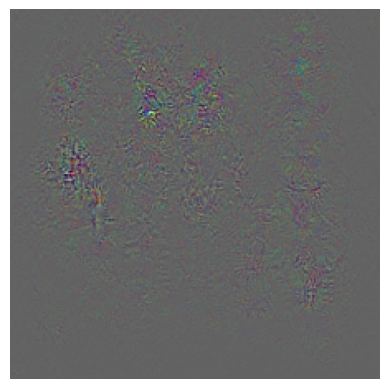

In [8]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# Custom Guided Backpropagation ReLU
class GuidedBackpropReLU(nn.Module):
    def forward(self, input):
        return torch.relu(input)

    def backward(self, grad_output):
        grad_input = torch.clamp(grad_output, min=0.0)
        return grad_input


# Replace ReLU with GuidedBackpropReLU
def replace_relu_with_guided(model):
    for name, module in model.named_children():
        if isinstance(module, nn.ReLU):
            setattr(model, name, GuidedBackpropReLU())
        else:
            replace_relu_with_guided(module)


# Preprocess the input image
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    return preprocess(image).unsqueeze(0)  # Add batch dimension


# Guided Backpropagation function
def guided_backpropagation(model, input_image, target_class):
    model.eval()  # Set model to evaluation mode
    input_image.requires_grad = True  # Enable gradient computation for input

    replace_relu_with_guided(model)  # Replace all ReLU activations

    output = model(input_image)  # Forward pass
    loss = output[0, target_class]  # Target class loss
    model.zero_grad()  # Zero out gradients
    loss.backward()  # Backward pass

    return input_image.grad.data  # Return gradients w.r.t. input image


# Visualize the gradients
def visualize_gradients(gradients):
    gradients = gradients[0].cpu().numpy()  # Remove batch dimension
    gradients = np.moveaxis(gradients, 0, -1)  # Rearrange channels to last dimension
    gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())  # Normalize
    plt.imshow(gradients)
    plt.axis('off')
    plt.show()


# Main script
if __name__ == "__main__":
    # Load a pretrained model
    model = models.vgg16(pretrained=True)

    # Load and preprocess the input image
    image_path = "/content/g2.jpeg"  # Replace with the path to your image
    input_image = preprocess_image(image_path)

    # Define target class (e.g., 'bull mastiff' class in ImageNet)
    target_class = 243

    # Move to device (CPU/GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    input_image = input_image.to(device)

    # Perform Guided Backpropagation
    gradients = guided_backpropagation(model, input_image, target_class)

    # Visualize the gradients
    visualize_gradients(gradients)


In [9]:
gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())  # Normalize


In [10]:
print("Gradient shape:", gradients.shape)


Gradient shape: torch.Size([1, 3, 224, 224])


In [11]:
output = model(input_image)
print("Model output:", output)


Model output: tensor([[-1.2584e+00, -1.8137e+00, -1.0226e+00, -1.1419e+00, -8.3491e-01,
         -1.2815e+00, -2.4777e+00, -1.0021e+00, -1.6242e+00, -1.6319e+00,
         -4.3073e-01, -1.8915e+00, -1.8908e+00, -1.7455e+00, -2.7198e+00,
         -1.0676e+00, -1.1592e+00, -2.1704e+00, -1.5549e+00, -1.3383e+00,
         -2.2149e+00, -1.5020e-01, -1.1805e+00, -1.1100e+00, -4.5525e-01,
          5.0912e-01,  1.7395e-01, -4.2468e-01,  3.9361e-02, -1.7142e+00,
         -1.2801e+00, -1.0444e+00,  5.6911e-02, -4.8359e-01, -6.5191e-01,
         -6.9288e-01, -7.8145e-01, -9.3500e-01, -8.1040e-01, -2.3831e+00,
         -1.1963e+00, -1.4915e+00, -1.4650e+00, -8.4594e-01, -1.8217e+00,
         -1.0687e+00, -2.1260e+00, -1.1661e+00, -2.6848e+00, -1.1802e+00,
         -1.7115e+00,  5.1491e-01, -9.1063e-01, -8.0351e-01, -7.0620e-01,
         -2.3235e+00, -2.4841e+00, -2.0297e+00, -1.9697e+00, -1.0031e+00,
         -5.8377e-01, -5.1533e-01,  5.7974e-01, -2.2703e-01, -1.1661e+00,
         -4.9224e-01, -5

In [12]:
gradients = guided_backpropagation(model, input_image, target_class)
print("Gradients shape:", gradients.shape)  # Should be [1, 3, 224, 224] for a single image


Gradients shape: torch.Size([1, 3, 224, 224])


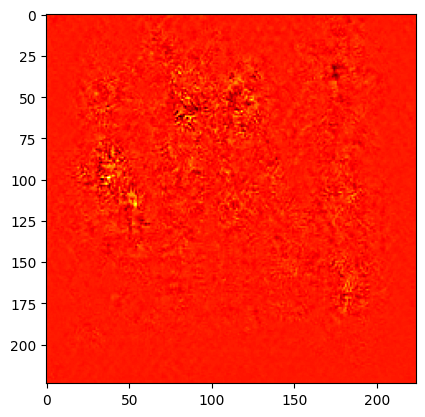

In [13]:
plt.imshow(gradients[0].cpu().numpy()[0], cmap='hot')  # Display the first channel's gradients
plt.show()